In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.5.1+cu124'

In [ ]:
!nvidia-smi

Tue Feb  4 05:59:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P0             27W /   70W |     158MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Sample data with known parameters
weight = 0.2
bias = 0.9

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [ ]:
# Train test split

train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
# Plot Predictions

def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label = "Training Data")
    plt.scatter(test_data, test_labels, c="y", s=4, label = "Testing Data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label = "Predictions")
    plt.legend(prop={"size": 14})
    plt.show()

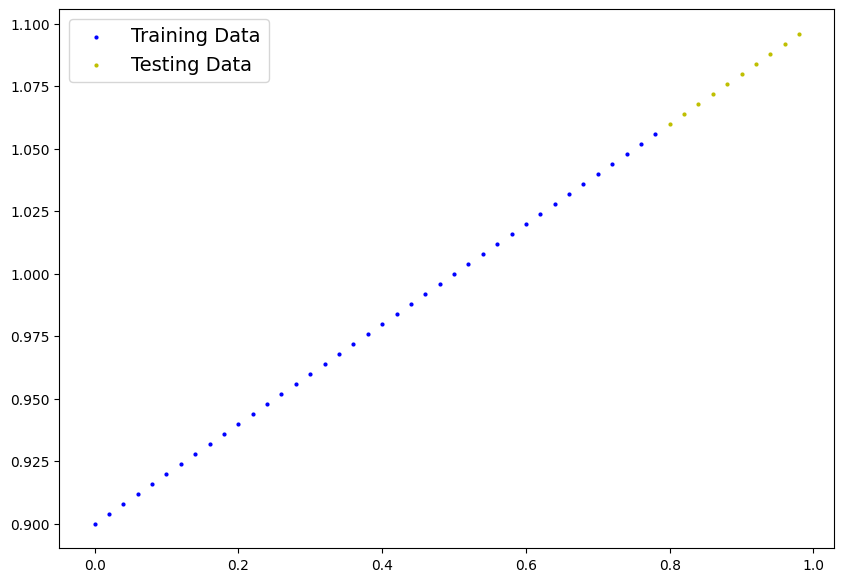

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

In [ ]:
# Creating the model

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating model params # Also called dense, fc, etc
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [ ]:
torch.manual_seed(42)
model = LinearRegressionModelV2()
model, model.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
next(model.parameters()).device

device(type='cpu')

In [ ]:
# Set model device

model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Setup loss function and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.01)

In [ ]:
# Training loop

epoch_history = []
train_loss_history = []
test_loss_history = []

# Put data on gpu
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):

  model.train()

  # Forward pass
  y_pred = model(X_train)

  # Calculate loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backpropagation
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

  epoch_history.append(epoch)
  train_loss_history.append(loss)
  test_loss_history.append(test_loss)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")


Epoch: 0 | Loss: 0.16281987726688385 | Test Loss: 0.4226631224155426
Epoch: 10 | Loss: 0.12239959090948105 | Test Loss: 0.3414849042892456
Epoch: 20 | Loss: 0.10434450954198837 | Test Loss: 0.28741690516471863
Epoch: 30 | Loss: 0.09563804417848587 | Test Loss: 0.25113144516944885
Epoch: 40 | Loss: 0.09046975523233414 | Test Loss: 0.22731833159923553
Epoch: 50 | Loss: 0.08649741858243942 | Test Loss: 0.2101965993642807
Epoch: 60 | Loss: 0.08300741761922836 | Test Loss: 0.19917680323123932
Epoch: 70 | Loss: 0.07951740175485611 | Test Loss: 0.18815702199935913
Epoch: 80 | Loss: 0.07602738589048386 | Test Loss: 0.17713725566864014
Epoch: 90 | Loss: 0.07258857786655426 | Test Loss: 0.168864905834198
Epoch: 100 | Loss: 0.06914976239204407 | Test Loss: 0.16059254109859467
Epoch: 110 | Loss: 0.06572125107049942 | Test Loss: 0.15300701558589935
Epoch: 120 | Loss: 0.0622849240899086 | Test Loss: 0.14473466575145721
Epoch: 130 | Loss: 0.05884772539138794 | Test Loss: 0.1371491551399231
Epoch: 140

In [ ]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.2050]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

In [ ]:
weight, bias

(0.2, 0.9)

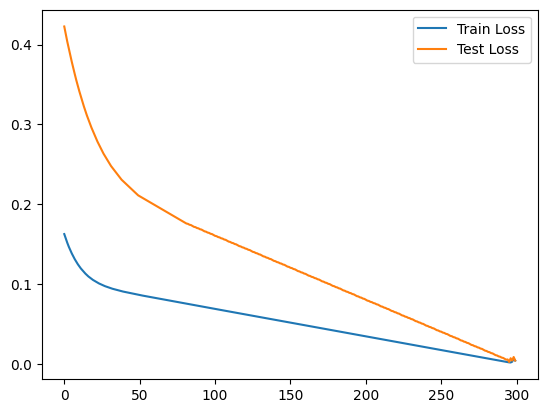

In [ ]:
plt.plot(epoch_history, np.array(torch.tensor(train_loss_history).cpu().numpy()), label = "Train Loss")
plt.plot(epoch_history, np.array(torch.tensor(test_loss_history).cpu().numpy()), label = "Test Loss")
plt.legend()

In [ ]:
model.eval()
with torch.inference_mode():
  y_pred = model(X_test)


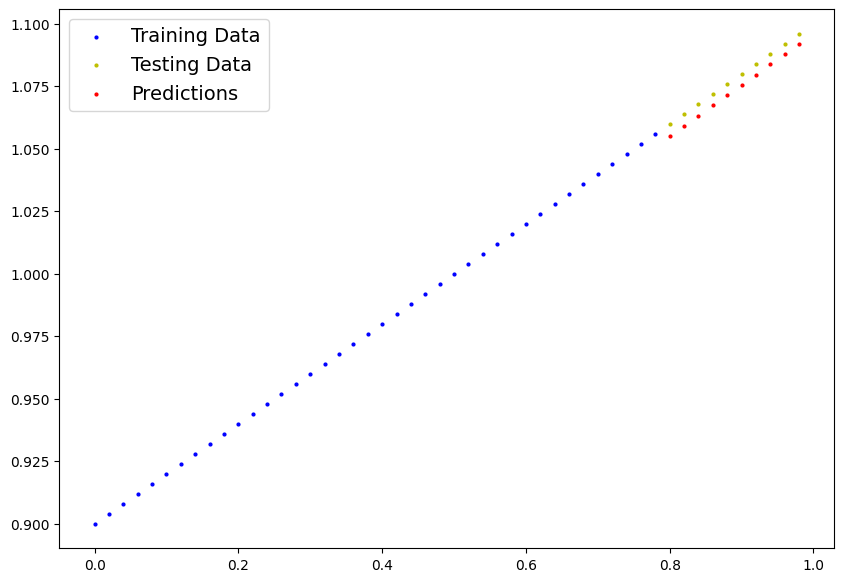

In [ ]:
plot_predictions(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test.cpu().numpy(), y_test.cpu().numpy(), predictions = np.array(y_pred.cpu().numpy()))

In [ ]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.2050]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

In [ ]:
# Saving and Loading

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "practice_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

In [ ]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1602 Feb  4 06:04 practice_model.pth


In [ ]:
loaded_model = LinearRegressionModelV2()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)

loaded_model.state_dict()

<ipython-input-148-192f1e7fe8ca>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


OrderedDict([('linear_layer.weight', tensor([[0.2050]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8910], device='cuda:0'))])

In [ ]:
loaded_model.eval()
with torch.inference_mode():
  y_preds = loaded_model(X_test)

y_pred == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')